# References

Pandas:

https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html

https://pandas.pydata.org/docs/user_guide/timeseries.html

# import modules

In [1]:
# imports
import pandas as pd
import numpy as np

# full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas format
pd.set_option('display.float_format', '{:_.0f}'.format)
# NOTE: underscore separaters ('_') are better than commas (',') because 
# numbers with underscores work in Python without any extra effort.
pd.set_option('display.max_columns', None)

# plotting modules
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
%matplotlib inline
mpl.rcParams["axes.formatter.min_exponent"] = 20  # no scientific notation in graphs
plt.rcParams['axes.titley'] = 1.0    # y is in axes-relative coordinates.
plt.rcParams['axes.titlepad'] = 10   # pad is in points... default is 6
import seaborn as sns
sns.set_theme()

stop wrapping text in tables / dataframes

In [2]:
%%html
<style>.dataframe td {white-space: nowrap;}</style>

# import data

In [3]:
# NOTE this file IS NOT ON GITHUB, it is too big, so it is in gitignore
# run the RV Database notebook to create this file from the cleaned tables

# entire database in one dataframe (df for simplicity)
df = pd.read_csv(
    'RV_DATABASE.csv', 
    dtype={'MATURITY':object, 
           'STRAT':object, 
           'TOTNO':'Int64', 
           'SPEC':'Int64',
           'SPECIMEN_ID':'Int64'},
    parse_dates=['DATETIME']  # need to parse the DATETIME field as pd.datetime format
)

# sort by datetime and reindex
df = df.sort_values('DATETIME').reset_index(drop=True)

In [4]:
# individual tables used to define the database
SPECIES = pd.read_csv('SPECIES.csv', index_col = 'index')
SPECIES.columns = ['SPEC', 'COMMON_NAME', 'SCIENTIFIC_NAME']
MISSIONS = pd.read_csv('MISSIONS.csv')
GSCAT = pd.read_csv('GSCAT.csv')
GSINF = pd.read_csv('GSINF.csv', index_col='date and time', parse_dates=['date and time'])  # parse index as pd.datetime format
GSINF.index.name = 'DATETIME'
GSDET = pd.read_csv('GSDET.csv')

# Helper Functions

In [5]:
def get_species(species_code):
    return SPECIES[SPECIES.SPEC == species_code].COMMON_NAME.tolist()[0]

### Haul Weights By Year (or Month), by Species, with Graphs

In [27]:
# format dataframes
# could be improved, single function, loop through columns, look for 'PROP' etc, format 
# could deal with by_weight=True

def format_monthly(dataframe):
    return dataframe.style.format({
        'SPEC_TOTAL': '{:_.2f}'.format,
        'MONTH_TOTAL': '{:_.2f}'.format,
        'PROP_TOTAL': '{:.2%}'.format
    })

def format_yearly(dataframe):
    return dataframe.style.format({
        'SPEC_TOTAL': '{:_.2f}'.format,
        'YEAR_TOTAL': '{:_.2f}'.format,
        'PROP_TOTAL': '{:.2%}'.format
    })

In [7]:
def filtered_yearly(data_filter = None, by_weight=False):
    """
    assumes df is the main dataframe with the entire database
    data_filter needs the same dataframe name as df
        would be hard to repurpose this function, so not worth fixing
    data_filter is a boolean using the following syntax:
    data_filter = (df.DEPTH > 100) & (df.SPEED > 5) 
    """

    # total weight or total number?
    if by_weight == False:
        total_haul, total_to_drop = 'TOTNO', 'TOTWGT'
    else:
        total_haul, total_to_drop = 'TOTWGT', 'TOTNO'
    
    # columns to include
    columns = ['DATETIME', 'MISSION', 'SETNO', 'TOTWGT', 'TOTNO', 'SPEC', 'COMMON_NAME']

    # filter the data
    if type(data_filter) == type(None):
        haul_weights_filtered = df[columns].drop_duplicates()
    else:
        haul_weights_filtered = df[data_filter][columns].drop_duplicates()
      
    # weights by species
    yearly_weight_by_species = (
        haul_weights_filtered
        .drop(['SETNO', total_to_drop], axis=1)
        .groupby([haul_weights_filtered['DATETIME'].dt.year, 'SPEC']).sum()
    )
    yearly_weight_by_species = yearly_weight_by_species.reset_index(level=1)
    yearly_weight_by_species.index.names = ['YEAR']

    # total weights (filtered totals)
    yearly_weight_totals = (
        haul_weights_filtered
        .drop(['SETNO', total_to_drop, 'SPEC'], axis=1)
        .groupby([haul_weights_filtered['DATETIME'].dt.year]).sum()
    )
    yearly_weight_totals.index.names = ['YEAR']

    # join the two dataframes
    yearly_weight_by_species = (
        yearly_weight_by_species
        .merge(yearly_weight_totals, how='outer', on=['YEAR'])
        .rename(columns={f'{total_haul}_x': 'SPEC_TOTAL', f'{total_haul}_y': 'YEAR_TOTAL'})
    )

    # calculate the proportion of species to the total
    yearly_weight_by_species['PROP_TOTAL'] = (
        yearly_weight_by_species['SPEC_TOTAL'] / yearly_weight_by_species['YEAR_TOTAL']
    )

    return yearly_weight_by_species

In [9]:
def filtered_monthly(data_filter = None, by_weight=False):
    """
    assumes df is the main dataframe with the entire database
    data_filter needs the same dataframe name as df
        would be hard to repurpose this function, so not worth fixing
    data_filter is a boolean using the following syntax:
    data_filter = (df.DEPTH > 100) & (df.SPEED > 5) 
    """
    # total weight or total number?
    if by_weight == False:
        total_haul, total_to_drop = 'TOTNO', 'TOTWGT'
    else:
        total_haul, total_to_drop = 'TOTWGT', 'TOTNO'
    
    # columns to include
    columns = ['DATETIME', 'MISSION', 'SETNO', 'TOTWGT', 'TOTNO', 'SPEC', 'COMMON_NAME']

    # filter the data
    if type(data_filter) == type(None):
        haul_weights_filtered = df[columns].drop_duplicates()
    else:
        haul_weights_filtered = df[data_filter][columns].drop_duplicates()
      
    # weights by species
    monthly_weight_by_species = (
        haul_weights_filtered
        .drop(['SETNO', total_to_drop], axis=1)
        .groupby([haul_weights_filtered['DATETIME'].dt.year, haul_weights_filtered['DATETIME'].dt.month, 'SPEC']).sum()
    )
    monthly_weight_by_species = monthly_weight_by_species.reset_index(level=2)
    monthly_weight_by_species.index.names = ['YEAR', 'MONTH']

    # total weights (filtered totals)
    monthly_weight_totals = (
        haul_weights_filtered
        .drop(['SETNO', total_to_drop, 'SPEC'], axis=1)
        .groupby([haul_weights_filtered['DATETIME'].dt.year, haul_weights_filtered['DATETIME'].dt.month]).sum()
    )
    monthly_weight_totals.index.names = ['YEAR', 'MONTH']

    # join the two dataframes
    monthly_weight_by_species = monthly_weight_by_species
    monthly_weight_by_species = (
        monthly_weight_by_species
        .merge(monthly_weight_totals, how='outer', on=['YEAR', 'MONTH'])
        .rename(columns={f'{total_haul}_x': 'SPEC_TOTAL', f'{total_haul}_y': 'MONTH_TOTAL'})
    )

    # calculate the proportion of species to the total
    monthly_weight_by_species['PROP_TOTAL'] = (
        monthly_weight_by_species['SPEC_TOTAL'] / monthly_weight_by_species['MONTH_TOTAL']
    )

    return monthly_weight_by_species

In [11]:
def filter_by_species(dataframe, species_code):
    dataframe = dataframe[dataframe.SPEC == species_code].copy()
    dataframe.drop('SPEC', axis=1, inplace=True)  # remove SPEC label
    return dataframe

In [12]:
def graph_species(dataframe, species_code, title=None, ylabel=None):
    """
    takes in an unfiltered dataframe, filters it, and plots the data
    """
    
    # species input
    spec_no = species_code
    species = get_species(spec_no)
    
    # filter the data
    filtered_data = filter_by_species(dataframe, spec_no)
    
    # label overrides
    if title == None:
        title=f'Proportion of Haul. Species: {species}.'
    if ylabel == None:
        ylabel='Proportion of Total'
    
    # graph the proportion of haul by species by year
    dataframe[dataframe.SPEC == spec_no].plot(
        kind='bar',
        width=1,
        y='PROP_TOTAL', 
        ylabel=ylabel,
        figsize=(30, 8), 
        legend=False, 
        title=title
    );

### TESTING

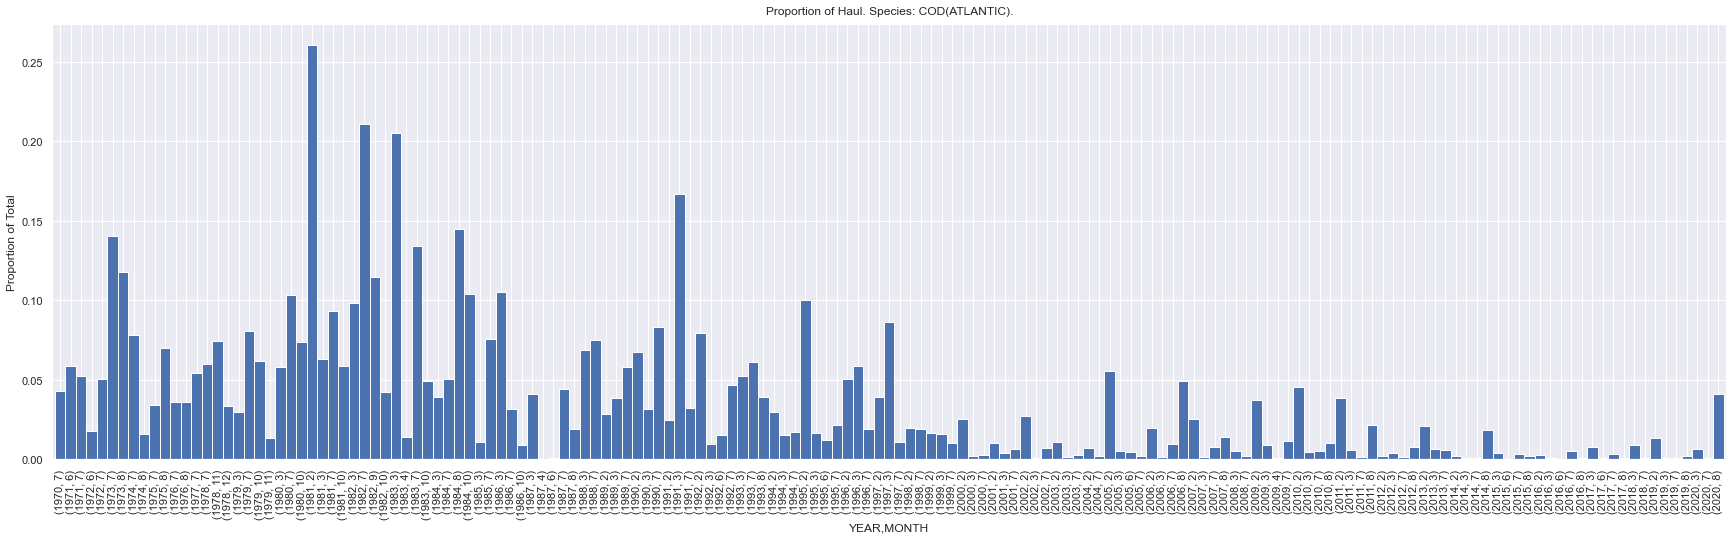

In [13]:
# filtered_monthly().head()
graph_species(filtered_monthly(), 10)

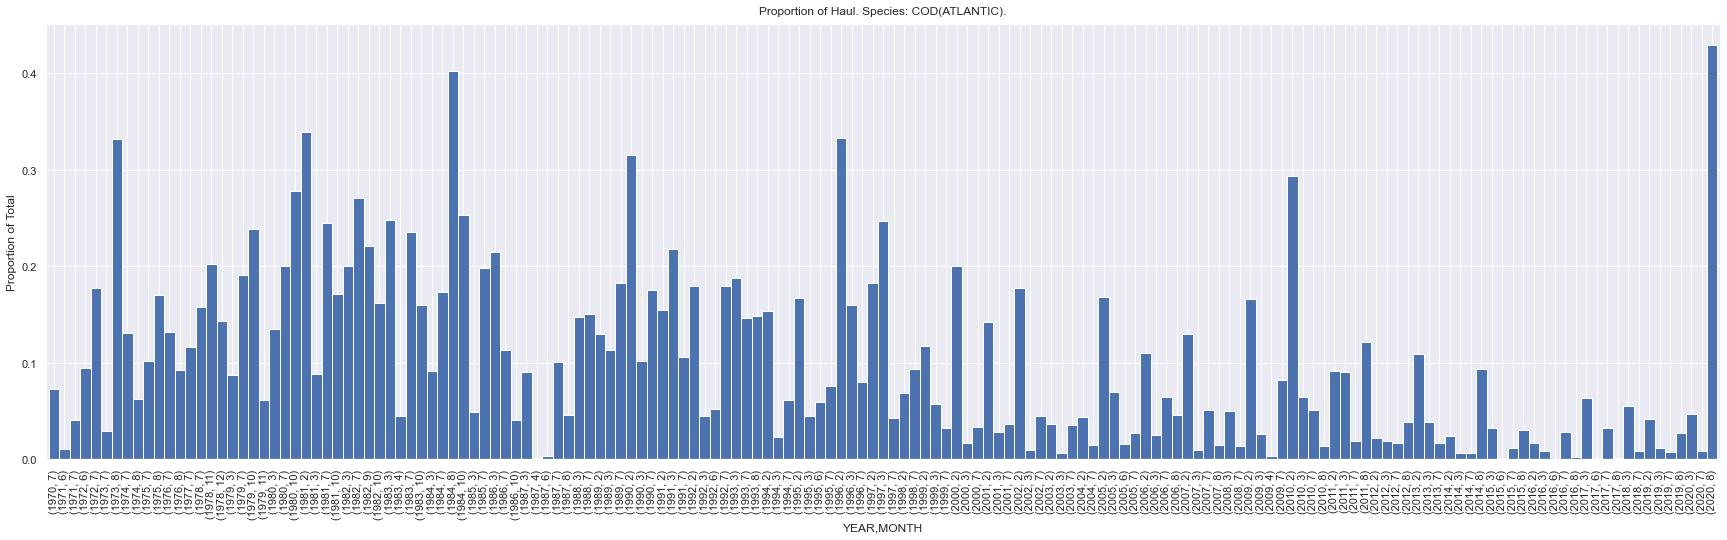

In [14]:
# filtered_monthly().head()
graph_species(filtered_monthly(by_weight=True), 10)

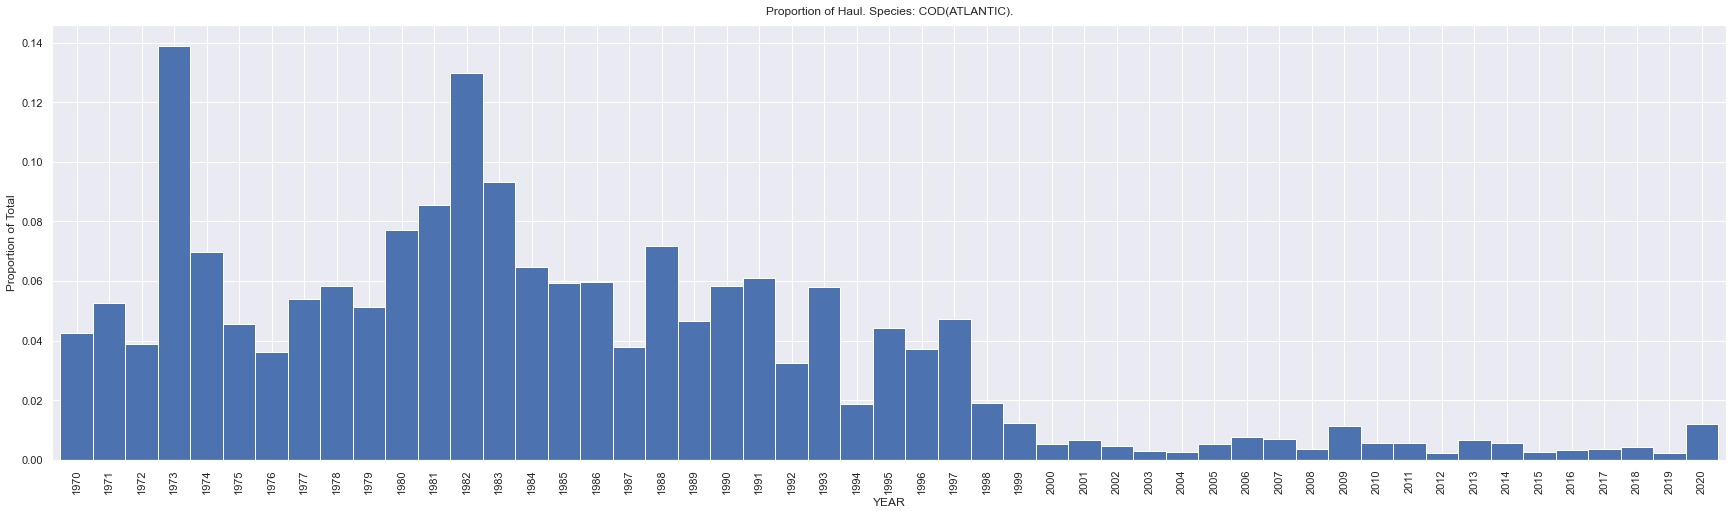

In [15]:
graph_species(filtered_yearly(), 10)

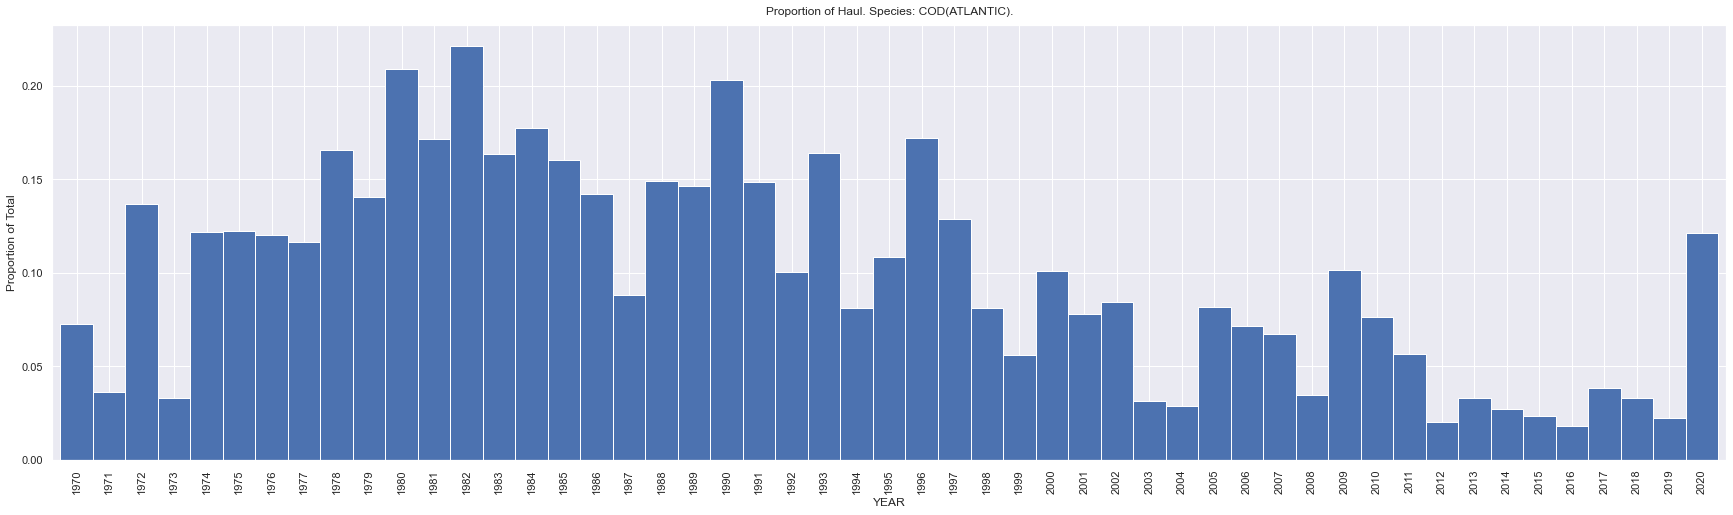

In [16]:
graph_species(filtered_yearly(by_weight=True), 10)

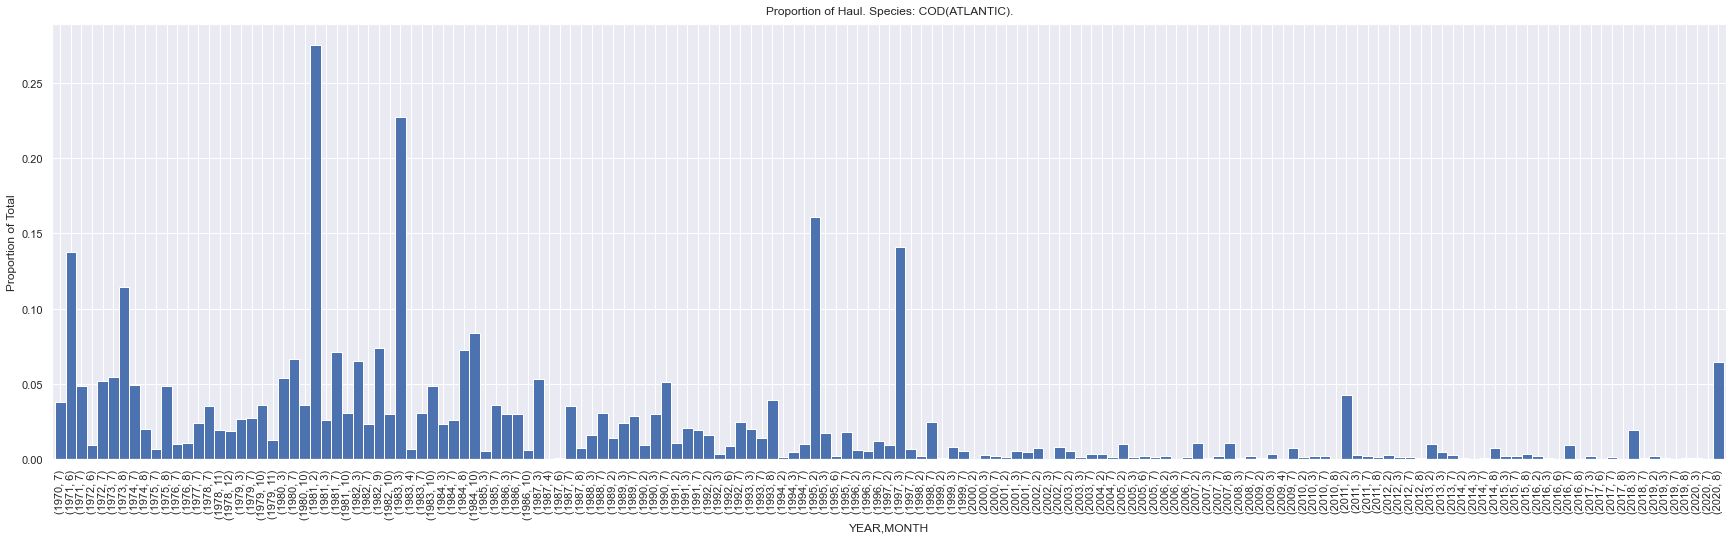

In [17]:
# check filter works
data_filter = (df.DEPTH > 100)
graph_species(filtered_monthly(data_filter), 10)

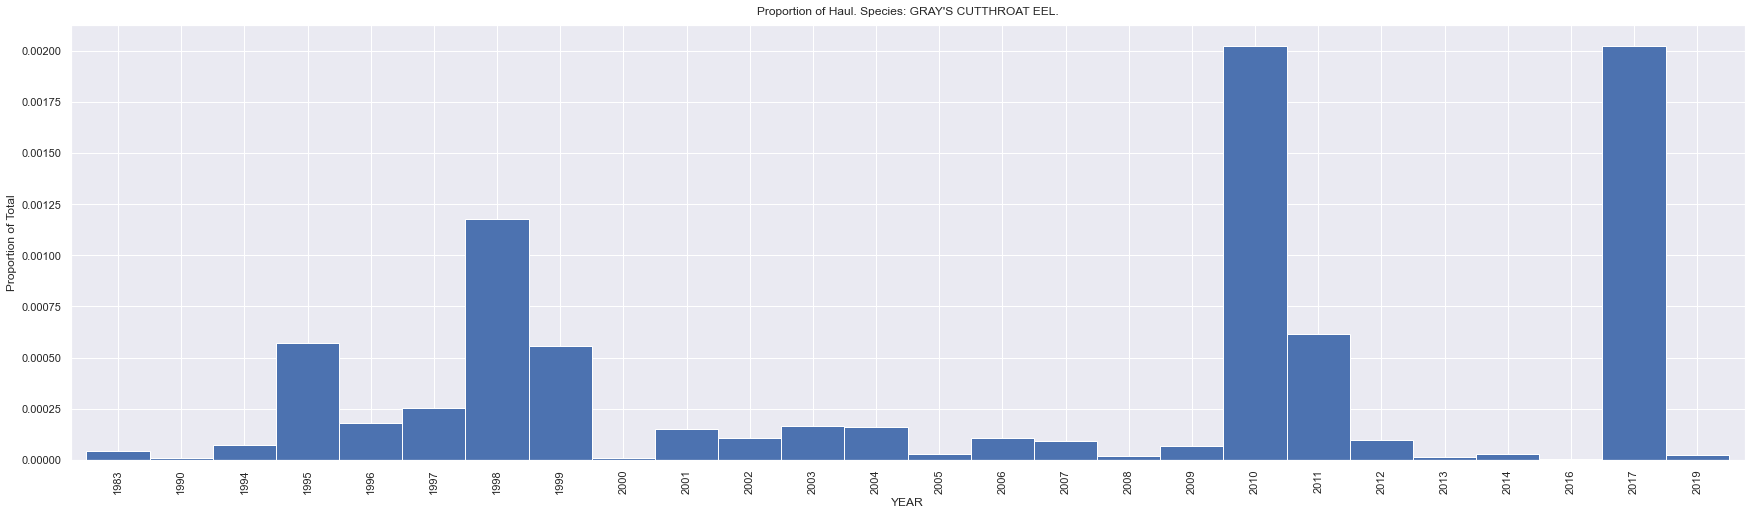

In [18]:
# check filter works
data_filter = (df.DEPTH > 100)
graph_species(filtered_yearly(data_filter), 602)

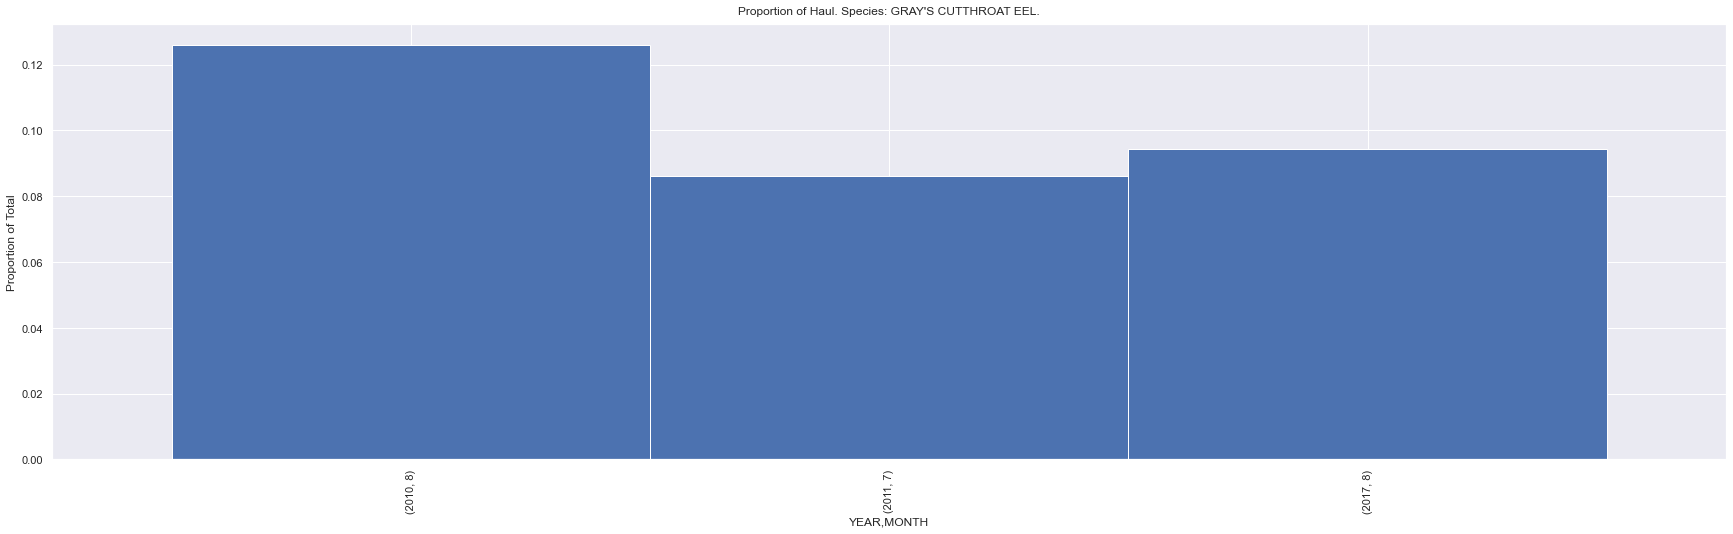

In [19]:
# which months were this super deep eel caught?
graph_species(filtered_monthly(df.DEPTH > 1000), 602)

In [28]:
# check percentages
data_filter = (df.DEPTH > 1800)
test = filtered_monthly(data_filter)
year_month = (2010, 8)
print(test[test.index == year_month].PROP_TOTAL.sum())
print()
format_monthly(test[test.index == year_month].sort_values('PROP_TOTAL', ascending=False).head(10))

1.0



In [29]:
# check percentages
data_filter = (df.DEPTH > 1800)
test = filtered_monthly(data_filter, by_weight=True)
year_month = (2010, 8)
print(test[test.index == year_month].PROP_TOTAL.sum())
print()
format_monthly(test[test.index == year_month].sort_values('PROP_TOTAL', ascending=False).head(10))

1.0000000000000002



### Mapping and Visualisation Functions

In [22]:
# TODO

# EDA

In [23]:
# TODO